# 互评作业2: 频繁模式与关联规则挖掘-Wine Reviews

## 1. 问题描述

选择1个数据集进行频繁模式和关联规则挖掘。
- **数据分析要求**
    - 对数据集进行处理，转换成适合进行关联规则挖掘的形式；
    - 找出频繁模式；
    - 导出关联规则，计算其支持度和置信度;
    - 对规则进行评价，可使用Lift、卡方和其它教材中提及的指标, 至少2种；
    - 对挖掘结果进行分析；
    - 可视化展示

**数据集：Wine Reviews**
此数据集包含两个csv文件：
- winemag-data_first150k.csv：10列，15万条数据
- winemag-data-130k-v2.csv：13列，13万条数据

选择分析winemag-data_first150k.csv数据文件，**数据属性**包括：
- country 国家 
- desprition 描述
- designation 酿酒厂内的葡萄园
- points 评分分数
- price 价格
- province 省份或洲
- region_1 一个省或州（即纳帕）的葡萄酒产区1
- region_2 葡萄酒产区指定的更具体的区域，但此值有时可能为空
- variety 葡萄品种
- winery 酿酒厂 

## 2. 对数据集进行处理，转换成适合进行关联规则挖掘的形式

### 2.1 导入数据

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
f_150k = "data/Wine-Reviews/winemag-data_first150k.csv"
data = pd.read_csv(f_150k, index_col=0)
data.head(5)

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [2]:
data.shape

(150930, 10)

In [3]:
data.dtypes

country         object
description     object
designation     object
points           int64
price          float64
province        object
region_1        object
region_2        object
variety         object
winery          object
dtype: object

In [4]:
# 统计所有属性的缺失值
print(data.isnull().sum(axis=0))

country            5
description        0
designation    45735
points             0
price          13695
province           5
region_1       25060
region_2       89977
variety            0
winery             0
dtype: int64


### 2.2 处理数据集中的不同属性

**（1）description属性是对于葡萄酒的自然语言描述，在分析过程中不做考虑。**

**（2）country、province、region_1和region_2标称属性属于葡萄酒产地的位置信息，仅选择country属性进行挖掘。通过数据探索性分析，country属性缺失值仅有5项，可以通过属性的相关关系来填补缺失值，使用葡萄酒的designation属性来判断其所属国家。**

In [5]:
# 获取country属性缺失的5条数据
attri = "country"
country_null = data.loc[data[attri].isnull()]
country_null["designation"].value_counts()

Piedra Feliz    3
Askitikos       1
Shah            1
Name: designation, dtype: int64

In [6]:
# 根据缺失值的分布，定义一个从designation到country的转换字典
designation2country = {
    "Askitikos":"Greece",    
    "Shah":"US",
    "Piedra Feliz":"Chile",
}

In [7]:
# 处理缺失值
# 获取country缺失值对应的index
ind = country_null.index.tolist()
ind

[1133, 1440, 68226, 113016, 135696]

In [8]:
# 补全数据
for i in ind:
    designation = data.iloc[i,2]
    data.iloc[i,0] = designation2country[designation]

In [9]:
# 探索country属性的不同取值个数
countrySeries = data["country"].value_counts()
countrySeries.size

48

**（3）points、price数值属性需进行离散化处理，为了区分二者需加上前缀"points-"和"price-"。通过数据探索性分析，可知：**
- points属性的最小值Min为80，最大值Max为100，points中大于等于97的项被识别为离群点
- price属性的最小值Min为4.0，最大值Max为2300.0，price中大于等于77的项被识别为离群点

In [10]:
def points_discretization(value):
    return "points-"+str(int(value/5))

def price_discretization(value):
    if value < 100:   # 设置price最高离散值为10
        return "price-"+str(int(value/10))
    else:
        return "price-10"

**（4）designation、variety、winery标称属性不同取值个数过多，通过探索新分析，不同取值个数分别为30622、632、14810，同时designation属性缺失项有45735个，在分析过程中不做考虑**

**最终，选取属性country、points、price进行频繁模式和关联规则挖掘。**

In [11]:
# 过滤属性
data = data.drop(['description', 'province', 'region_1',
                  'region_2', 'variety', 'winery', 'designation'], axis=1)
data.head(5)

,country,points,price
0,US,96,235.0
1,Spain,96,110.0
2,US,96,90.0
3,US,96,65.0
4,France,95,66.0


In [12]:
# points、price数值属性离散化处理
data.loc[:, 'points'] = data['points'].map(lambda x: points_discretization(x))
data.loc[:, 'price'] = data['price'].map(lambda x: price_discretization(x))
data.head(5)

,country,points,price
0,US,points-19,price-10
1,Spain,points-19,price-10
2,US,points-19,price-9
3,US,points-19,price-6
4,France,points-19,price-6


### 2.3 将DataFrame转换为TDB

In [13]:
# 将dataframe转换为列表
def trans_list(x):
    return x.dropna().tolist() 
data_list = data.apply(trans_list, axis=1).tolist()
data_list

[['US', 'points-19', 'price-10'],
 ['Spain', 'points-19', 'price-10'],
 ['US', 'points-19', 'price-9'],
 ['US', 'points-19', 'price-6'],
 ['France', 'points-19', 'price-6'],
 ['Spain', 'points-19', 'price-7'],
 ['Spain', 'points-19', 'price-6'],
 ['Spain', 'points-19', 'price-10'],
 ['US', 'points-19', 'price-6'],
 ['US', 'points-19', 'price-6'],
 ['Italy', 'points-19', 'price-8'],
 ['US', 'points-19', 'price-4'],
 ['US', 'points-19', 'price-4'],
 ['France', 'points-19', 'price-9'],
 ['US', 'points-19', 'price-10'],
 ['US', 'points-19', 'price-9'],
 ['US', 'points-19', 'price-10'],
 ['Spain', 'points-19', 'price-8'],
 ['France', 'points-19', 'price-10'],
 ['US', 'points-19', 'price-7'],
 ['US', 'points-19', 'price-2'],
 ['Spain', 'points-19', 'price-7'],
 ['Spain', 'points-19', 'price-10'],
 ['US', 'points-19', 'price-6'],
 ['US', 'points-19', 'price-4'],
 ['New Zealand', 'points-18', 'price-5'],
 ['US', 'points-18', 'price-6'],
 ['US', 'points-18', 'price-10'],
 ['US', 'points-18', 'p

In [14]:
# 利用TransactionEncoder转换为模型可接受数据
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()   # 定义模型
tf = te.fit_transform(data_list)  # type(tf): numpy.ndarray
data_df = pd.DataFrame(tf, columns=te.columns_)
data_df

,Albania,Argentina,Australia,Austria,Bosnia and Herzegovina,Brazil,Bulgaria,Canada,Chile,China,...,price-1,price-10,price-2,price-3,price-4,price-5,price-6,price-7,price-8,price-9
0,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150925,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
150926,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
150927,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
150928,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


## 3. 找出频繁模式

**调用mlxtend中的apriori函数，最小支持度阈值取0.03**

In [15]:
from mlxtend.frequent_patterns import apriori

# use_colnames=True表示使用元素名字，默认的False使用列名代表元素
frequent_itemsets = apriori(
    data_df, min_support=0.03, use_colnames=True, max_len=4)
# 频繁项集按支持度排序
frequent_itemsets.sort_values(by='support', ascending=False, inplace=True)
print(frequent_itemsets.shape)
frequent_itemsets[:20]

(52, 2)


,support,itemsets
9,0.526887,(points-17)
7,0.413423,(US)
12,0.303419,(price-1)
10,0.299669,(points-18)
14,0.212986,(price-2)
37,0.201034,"(price-1, points-17)"
29,0.199788,"(US, points-17)"
4,0.155556,(Italy)
8,0.153694,(points-16)
3,0.139787,(France)


## 4. 导出关联规则，计算其支持度和置信度

**使用mlxtend中的association_rules方法，最小支持度阈值取0.03，最小置信度阈值取0.4**

`mlxtend`使用了`DataFrame`方式来描述关联规则，而不是蕴涵（->）符号，其中：

- antecedents：规则先导项
- consequents：规则后继项
- antecedent support：规则先导项支持度
- consequent support：规则后继项支持度
- support：规则支持度 （前项后项并集的支持度）
- confidence：规则置信度 （规则置信度：规则支持度support / 规则先导项support）
- lift：规则提升度，表示含有先导项条件下同时含有后继项的概率，与后继项总体发生的概率之比。

In [16]:
from mlxtend.frequent_patterns import association_rules
# metric可以有很多的度量选项，返回的表列名都可以作为参数
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.4)
rules = rules.drop(['leverage', 'conviction'], axis=1)
print(rules.shape)
rules

(28, 7)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,(price-1),(points-17),0.303419,0.526887,0.201034,0.662561,1.257503
1,(US),(points-17),0.413423,0.526887,0.199788,0.483253,0.917185
2,(price-2),(points-17),0.212986,0.526887,0.131604,0.617900,1.172737
3,(points-18),(US),0.299669,0.413423,0.128748,0.429636,1.039215
4,(price-2),(US),0.212986,0.413423,0.106460,0.499844,1.209038
5,(Italy),(points-17),0.155556,0.526887,0.093964,0.604055,1.146461
6,(points-16),(price-1),0.153694,0.303419,0.079454,0.516963,1.703795
7,(price-3),(US),0.124554,0.413423,0.076784,0.616469,1.491132
8,(points-16),(US),0.153694,0.413423,0.076048,0.494805,1.196849
9,(France),(points-17),0.139787,0.526887,0.066998,0.479287,0.909659


**导出关联规则：形如X→Y的蕴涵表达式**

In [17]:
for index, row in rules.iterrows():
    t1 = tuple(row['antecedents'])
    t2 = tuple(row['consequents'])
    print("%s → %s (suupport = %f, confidence = %f )" %
          (t1, t2, row['support'], row['confidence']))

('price-1',) → ('points-17',) (suupport = 0.201034, confidence = 0.662561 )
('US',) → ('points-17',) (suupport = 0.199788, confidence = 0.483253 )
('price-2',) → ('points-17',) (suupport = 0.131604, confidence = 0.617900 )
('points-18',) → ('US',) (suupport = 0.128748, confidence = 0.429636 )
('price-2',) → ('US',) (suupport = 0.106460, confidence = 0.499844 )
('Italy',) → ('points-17',) (suupport = 0.093964, confidence = 0.604055 )
('points-16',) → ('price-1',) (suupport = 0.079454, confidence = 0.516963 )
('price-3',) → ('US',) (suupport = 0.076784, confidence = 0.616469 )
('points-16',) → ('US',) (suupport = 0.076048, confidence = 0.494805 )
('France',) → ('points-17',) (suupport = 0.066998, confidence = 0.479287 )
('price-3',) → ('points-17',) (suupport = 0.062327, confidence = 0.500399 )
('US', 'price-2') → ('points-17',) (suupport = 0.060757, confidence = 0.570700 )
('price-2', 'points-17') → ('US',) (suupport = 0.060757, confidence = 0.461662 )
('US', 'price-1') → ('points-17',)

## 5. 对规则进行评价

**评价指标：Lift(提升度)、Allconf(全置信度)和Jaccard系数**

In [18]:
def allconf(x):
    return x.support/max(x['antecedent support'], x['consequent support'])


def jaccard(x):
    return x.support/(x['antecedent support']+x['consequent support']-x.support)


# 计算Allconf
allconf_list = []
jaccard_list = []
for index, row in rules.iterrows():
    allconf_list.append(allconf(row))
    jaccard_list.append(jaccard(row))
rules['allconf'] = allconf_list
rules['jaccard'] = jaccard_list
rules = rules.drop(['antecedent support', 'consequent support'], axis=1)
rules

,antecedents,consequents,support,confidence,lift,allconf,jaccard
0,(price-1),(points-17),0.201034,0.662561,1.257503,0.381550,0.319470
1,(US),(points-17),0.199788,0.483253,0.917185,0.379186,0.269793
2,(price-2),(points-17),0.131604,0.617900,1.172737,0.249777,0.216358
3,(points-18),(US),0.128748,0.429636,1.039215,0.311420,0.220330
4,(price-2),(US),0.106460,0.499844,1.209038,0.257508,0.204750
5,(Italy),(points-17),0.093964,0.604055,1.146461,0.178338,0.159673
6,(points-16),(price-1),0.079454,0.516963,1.703795,0.261863,0.210386
7,(price-3),(US),0.076784,0.616469,1.491132,0.185727,0.166489
8,(points-16),(US),0.076048,0.494805,1.196849,0.183948,0.154863
9,(France),(points-17),0.066998,0.479287,0.909659,0.127158,0.111724


**过滤Allconf小于0.1和Jaccard小于0.1的规则，按照Lift降序排列，得到用于分析的关联规则。**

In [19]:
final_rules = rules.loc[rules['allconf'] > 0.1].loc[rules['jaccard'] > 0.1]
final_rules = final_rules.sort_values(by=['lift'], ascending=False)
final_rules

,antecedents,consequents,support,confidence,lift,allconf,jaccard
16,(price-10),(France),0.049930,0.422706,3.023936,0.357190,0.240076
19,(price-4),(points-18),0.043855,0.529393,1.766594,0.146344,0.129497
6,(points-16),(price-1),0.079454,0.516963,1.703795,0.261863,0.210386
7,(price-3),(US),0.076784,0.616469,1.491132,0.185727,0.166489
14,(price-10),(points-18),0.051898,0.439365,1.466169,0.173185,0.141841
17,(price-4),(US),0.049692,0.599856,1.450948,0.120196,0.111274
15,(price-3),(points-18),0.049990,0.401351,1.339316,0.166818,0.133580
0,(price-1),(points-17),0.201034,0.662561,1.257503,0.381550,0.319470
4,(price-2),(US),0.106460,0.499844,1.209038,0.257508,0.204750
8,(points-16),(US),0.076048,0.494805,1.196849,0.183948,0.154863


## 6. 对挖掘结果进行分析

**根据不同指标分析关联规则**

**Lift指标值较大或较小的规则（关联性较强）有6条：**

In [20]:
i = 1
for index, row in final_rules.iterrows():
    t1 = tuple(row['antecedents'])
    t2 = tuple(row['consequents'])
    if row['lift'] > 1.45 or row['lift'] < 0.5:
        print("%d : %s → %s (lift = %f)" % (i, t1, t2, row['lift']))
        i = i + 1

1 : ('price-10',) → ('France',) (lift = 3.023936)
2 : ('price-4',) → ('points-18',) (lift = 1.766594)
3 : ('points-16',) → ('price-1',) (lift = 1.703795)
4 : ('price-3',) → ('US',) (lift = 1.491132)
5 : ('price-10',) → ('points-18',) (lift = 1.466169)
6 : ('price-4',) → ('US',) (lift = 1.450948)


**allconf和jaccard指标值较大的规则（关联性较强）有6条：**

In [21]:
i = 1
for index, row in final_rules.iterrows():
    t1 = tuple(row['antecedents'])
    t2 = tuple(row['consequents'])
    if row['allconf'] > 0.25 and row['jaccard'] > 0.20:
        print("%d : %s → %s (allconf = %f, jaccard = %f)" %
              (i, t1, t2, row['allconf'], row['jaccard']))
        i = i + 1

1 : ('price-10',) → ('France',) (allconf = 0.357190, jaccard = 0.240076)
2 : ('points-16',) → ('price-1',) (allconf = 0.261863, jaccard = 0.210386)
3 : ('price-1',) → ('points-17',) (allconf = 0.381550, jaccard = 0.319470)
4 : ('price-2',) → ('US',) (allconf = 0.257508, jaccard = 0.204750)
5 : ('points-18',) → ('US',) (allconf = 0.311420, jaccard = 0.220330)
6 : ('US',) → ('points-17',) (allconf = 0.379186, jaccard = 0.269793)


**因此可以得出：**

- 价格对葡萄酒的评分存在一定的影响。
    - 价格比较低（price-1和price-2，对应价格区间为10-29）的葡萄酒的评分更多地集中在16和17的评分档位（对应百分制评分的80-89）；
    - 价格相对较高的葡萄酒（price-3到price-10，价格为30以上的）评分集中在18的评分档位（对应百分制评分的90-95）
- 来自美国的葡萄酒的价格相对较低（price-1到price-3）。 
- 来自法国的葡萄酒的价格较高（price-10）

## 7. 可视化展示

**（1）support-confidence散点图绘制**

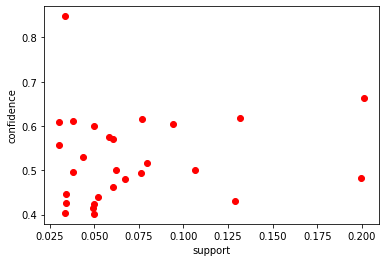

In [22]:
import  matplotlib.pyplot as plt
plt.xlabel('support')
plt.ylabel('confidence')
for i in range(rules.shape[0]):
    plt.scatter(rules.support[i],rules.confidence[i],c='r')

**（2）support-lift散点图绘制**

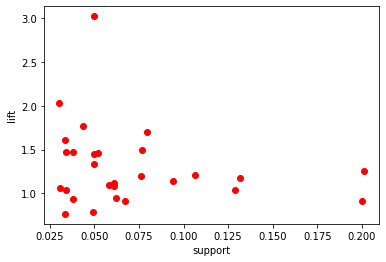

In [23]:
plt.xlabel('support')
plt.ylabel('lift')
for i in range(rules.shape[0]):
    plt.scatter(rules.support[i],rules.lift[i],c='r')

**（3）Allconf热力图绘制**

将rules按规则先导项和规则后继项两个维度进行数据透视，进行绘制

In [24]:
import seaborn as sns
hm_rules = rules.pivot(index='antecedents',
                       columns='consequents', values='allconf')
hm_rules.fillna(0.0, inplace=True)
hm_rules

consequents,(points-17),(US),(price-1),(points-18),(France)
antecedents,,,,,
(price-1),0.381550,0.000000,0.000000,0.000000,0.00000
"(Italy, price-1)",0.063441,0.000000,0.000000,0.000000,0.00000
(price-2),0.249777,0.257508,0.000000,0.000000,0.00000
"(points-16, price-1)",0.000000,0.082086,0.000000,0.000000,0.00000
"(US, points-16)",0.000000,0.000000,0.111846,0.000000,0.00000
"(price-3, points-17)",0.000000,0.092070,0.000000,0.000000,0.00000
"(US, price-3)",0.072243,0.000000,0.000000,0.000000,0.00000
(price-4),0.063353,0.120196,0.000000,0.146344,0.00000
(price-10),0.093193,0.000000,0.000000,0.173185,0.35719


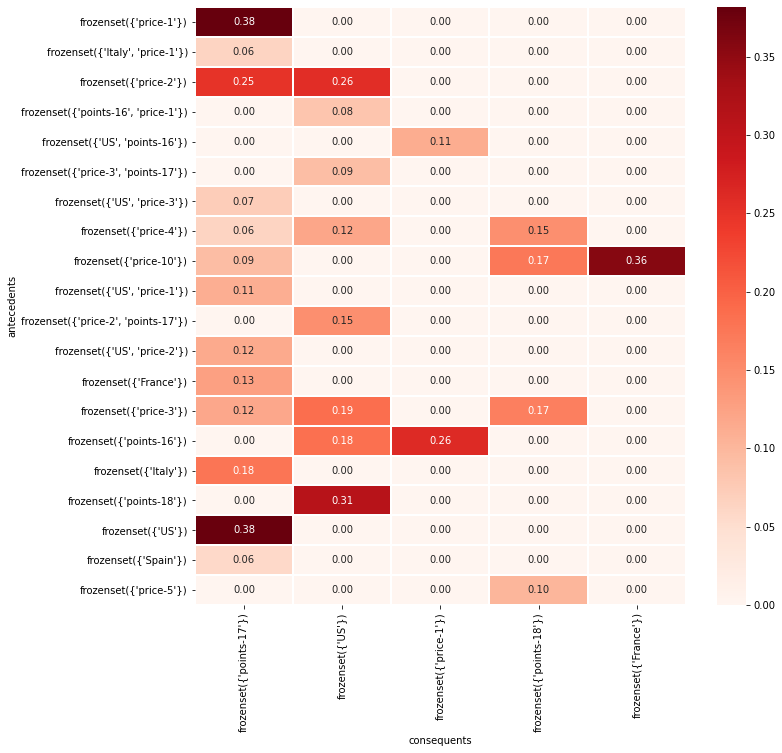

In [25]:
plt.figure(figsize=(11, 11))
sns.heatmap(data=hm_rules, annot=True, linewidths=0.3, fmt=".2f", cmap="Reds")
plt.show()